<b><font color='darkred'>
CNN - Convolutional Neural Network
-----------------
➔ Einfaches CNN 

- Subsample-Länge nun 150 (ca. jeder 10. Datenpunkt)
- mehrere `Conv1D`-Layer
- `Dense`-Layer zum Zusammenfassen zu einem Skalar
- `Lambda` skaliert Vorhersage um Faktor 2000 (damit kann Vorhersage zwischen 0 und 1 liegen)
- reagiert sehr empfindlich auf learning_rate (kein Lernfortschritt)
- `Conv1D` mit `stride` scheint besser als `MaxPool1D` zu funktionieren


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics, manifold
from tensorflow import keras
import keras_tuner as kt

import helper

In [21]:
best_subsample_size = 32
SCALE = 1 # hier: lambda

In [22]:
zugversuche, kurven, versuche_train, versuche_test = helper.read_data()

In [23]:
versuche_train_valid, versuche_test_valid = model_selection.train_test_split(versuche_train, test_size=0.1, random_state=42)
versuche_train_valid.shape, versuche_test_valid.shape, versuche_test.shape

# versuche_train       = versuche_train_valid
# versuche_train_valid = versuche_train
# versuche_test_valid  = versuche_valid

((432, 5), (48, 5), (120, 5))

In [24]:
subsample = helper.Subsample(best_subsample_size, ts_len=None)
subsample.fit()

Subsample(subsample=32)

In [25]:
X_train = subsample.transform(versuche_train_valid.key, kurven)
label_train      = versuche_train_valid.label.values
festigkeit_train = versuche_train_valid.festigkeit.values

print(X_train.shape, label_train.shape)
print(X_train.max(axis=(0,1)))

X_valid = subsample.transform(versuche_test_valid.key, kurven)
label_valid      = versuche_test_valid.label.values
festigkeit_valid = versuche_test_valid.festigkeit.values

print(X_valid.shape, label_valid.shape)
print(X_valid.max(axis=(0,1)))

X_test = subsample.transform(versuche_test.key, kurven)
label_test      = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values

print(X_test.shape)
print(X_test.max(axis=(0,1)))

(432, 32, 3) (432,)
[3563.91   625.019    4.14 ]
(48, 32, 3) (48,)
[3419.39   623.066    3.98 ]
(120, 32, 3)
[3532.82   623.066    3.82 ]


<b><font color='lightgreen'> Augmentation

In [26]:
X_valid, festigkeit_valid = helper.augment_curves(X_valid, festigkeit_valid)
X_valid.shape, festigkeit_valid.shape

((528, 32, 3), (528,))

In [27]:
X_train, X_valid, festigkeit_train, festigkeit_valid = model_selection.train_test_split(
    X_valid, festigkeit_valid, test_size=0.15, random_state=23
)
X_train.shape, festigkeit_train.shape, X_valid.shape, festigkeit_valid.shape

((448, 32, 3), (448,), (80, 32, 3), (80,))

<b><font color='lightgreen'> Daten skalieren

In [28]:
tsMaxScale = helper.TsMaxScaler()
X_train_scaled = tsMaxScale.fit_transform(X_train)
X_valid_scaled = tsMaxScale.transform(X_valid)
X_test_scaled = tsMaxScale.transform(X_test)

festigkeit_train = festigkeit_train/SCALE
festigkeit_valid = festigkeit_valid/SCALE
festigkeit_test  = festigkeit_test/SCALE

<b><font color='lightgreen'> Darstellung der Schweisskurven X_train

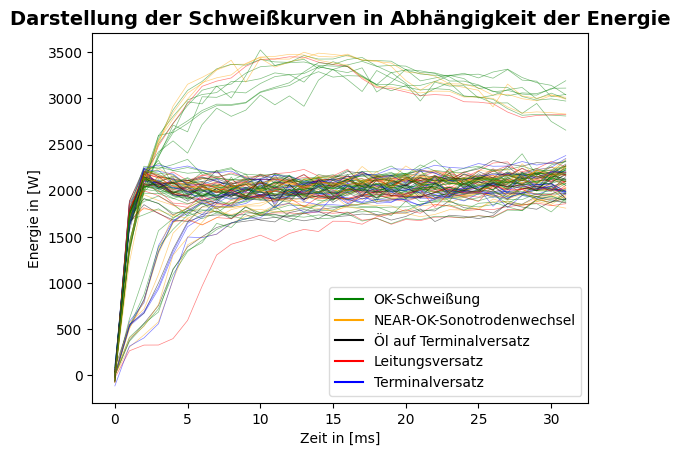

In [29]:
helper.plot_curves(X_train[:100,:,:], 0, label_train[:100], 'power')

<font color='lightgreen'> alle features verwenden

In [30]:
dims = X_train.shape
X2_train = X_train_scaled
X2_valid = X_valid_scaled
X2_test  = X_test_scaled
X2_train.shape

(448, 32, 3)

<b><font color='lightgreen'> Hyperparametersuche

In [31]:
def build_class(hp):
    #n_cnn = hp.Int("n_cnn", min_value=1, max_value=5, default=2)
    n_kernel_size = hp.Int("n_kernel_size", min_value=2, max_value=8, default=5)
    n_pool_size   = hp.Int("n_pool_size",   min_value=2, max_value=4, default=2)
    n_neurons     = hp.Int("n_neurons",     min_value=64, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling='log')
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=X2_train.shape[1:]))
    model.add(keras.layers.Conv1D(
        filters=n_neurons, kernel_size=(n_kernel_size,),
        activation='relu',
    ))
    model.add(keras.layers.MaxPool1D(
        pool_size=n_pool_size,
    ))
    model.add(keras.layers.Conv1D(
        filters=n_neurons, kernel_size=(n_kernel_size,),
        activation='relu',
    ))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(n_neurons, use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dense(1, activation='relu'))
    model.add(keras.layers.Lambda(lambda x: x*2000.0))
    model.compile(
        loss='mse',
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    )
    return model

In [32]:
random_search_tuner = kt.RandomSearch(
    build_class, 
    objective='val_loss', 
    overwrite=True, 
    max_trials=10,
    directory='Modelle/cnn', project_name='cnn_reg',
)
#random_search_tuner.search(X2_train, festigkeit_train, epochs=30, batch_size=8,
#    validation_data=(X2_valid, festigkeit_valid)
#)

<b><font color='lightgreen'> => manuelles Modell aus mehreren Hyperparametersuchen

In [33]:
model_reg = keras.models.Sequential()
model_reg.add(keras.layers.Input(shape=X2_train.shape[1:]))
model_reg.add(keras.layers.Conv1D(
    filters=128, kernel_size=(15,),
    activation='relu',
))
#model_reg.add(keras.layers.MaxPool1D(
#    pool_size=4,
#))
model_reg.add(keras.layers.Conv1D(
    filters=128, kernel_size=(8,),
    strides=3,
    activation='relu',
))
#model_reg.add(keras.layers.MaxPool1D(
#    pool_size=2,
#))
model_reg.add(keras.layers.Conv1D(
    filters=128, kernel_size=(4,),
    strides=2,
    activation='relu',
))
model_reg.add(keras.layers.Flatten())
#model_reg.add(keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'))
model_reg.add(keras.layers.Dense(1, activation='relu', kernel_initializer='he_normal'))
model_reg.add(keras.layers.Lambda(lambda x: x*2000.0))

model_reg.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss='mse',
)
model_reg.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 18, 128)           5888      
                                                                 
 conv1d_8 (Conv1D)           (None, 4, 128)            131200    
                                                                 
 conv1d_9 (Conv1D)           (None, 1, 128)            65664     
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
 lambda_3 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 202881 (792.50 KB)
Trainable params: 202

In [34]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True
)

hist = model_reg.fit(X2_train, festigkeit_train, epochs=100, batch_size=16,
    validation_data=(X2_valid, festigkeit_valid),
    callbacks=[early_stopping]
)
y_pred_valid = model_reg.predict(X2_valid)
metrics.mean_squared_error(festigkeit_valid, y_pred_valid)

Epoch 1/100
28/28 [==============================] - 0s 4ms/step - loss: 3055451.5000 - val_loss: 1432390.5000
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 907504.1250 - val_loss: 963141.1875
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 701857.8125 - val_loss: 836648.8125
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 630601.6250 - val_loss: 734535.3750
Epoch 5/100
28/28 [==============================] - 0s 3ms/step - loss: 535779.5000 - val_loss: 609575.3750
Epoch 6/100
28/28 [==============================] - 0s 3ms/step - loss: 429535.9062 - val_loss: 466510.1562
Epoch 7/100
28/28 [==============================] - 0s 3ms/step - loss: 324181.4688 - val_loss: 347592.5000
Epoch 8/100
28/28 [==============================] - 0s 3ms/step - loss: 237421.7656 - val_loss: 240023.5781
Epoch 9/100
28/28 [==============================] - 0s 3ms/step - loss: 173625.2969 - val_loss: 174514.1562
Epoch 10/100
28/2

23296.39050367235

<b><font color='lightgreen'> Verlauf des Trainingsprozesses

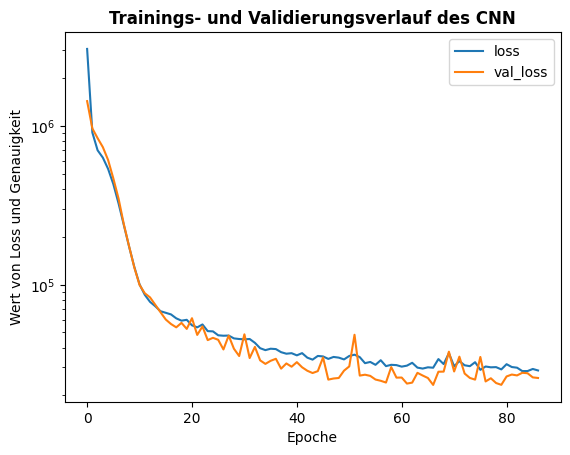

In [35]:
pd.DataFrame(hist.history).plot(logy=True)
plt.xlabel("Epoche")
plt.ylabel("Wert von Loss und Genauigkeit")
plt.title("Trainings- und Validierungsverlauf des CNN", weight='bold')
plt.show()

best_hps = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]
print("Beste gefundene Hyperparameter:")
for param in best_hps.values.keys():
    print(f"{param}: {best_hps.get(param)}")

<b><font color='lightgreen'> Vorhersage Trainings-, Validierungs- und Testdaten

In [36]:
y_pred_train = model_reg.predict(X2_train)
y_pred_test  = model_reg.predict(X2_test)
y_pred_valid = model_reg.predict(X2_valid)

3/3 [==============================] - 0s 1ms/step


helper.plot_pred(y_pred_train, festigkeit_train, label_train, 'CNN Trainingsdaten', 'mit Linie', SCALE)
helper.plot_pred(y_pred_test,  festigkeit_test,  label_test,  'CNN Testdaten', 'mit Linie', SCALE)
helper.plot_pred(y_pred_valid, festigkeit_valid, label_valid, 'CNN Validierungsdaten', 'mit Linie', SCALE)

<b><font color='lightgreen'> Modellbewertung</b>

In [41]:
helper.get_metric_table_regr(festigkeit_train, y_pred_train, festigkeit_test, y_pred_test, SCALE)

,Train,Test
Metric,,
MSE,30596.99,23321.08
RMSE,174.92,152.71
MAE,132.07,107.76
R²,0.96,0.97
